In [2]:
import sys
sys.path.append('/opt/anaconda3/lib/python3.12/site-packages')
import kagglehub


c:\Users\Mirko\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import kagglehub

path = kagglehub.dataset_download("minasameh55/king-country-houses-aa")

print("Path to dataset files:", path)

100%|██████████| 780k/780k [00:00<00:00, 1.58MB/s]

Extracting files...
Path to dataset files: C:\Users\Mirko\.cache\kagglehub\datasets\minasameh55\king-country-houses-aa\versions\1


In [6]:
#libraries

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [8]:
import os
os.getcwd()

'c:\\Data_Science\\IH_Notebooks\\IronKaggle_project'

In [14]:
data = pd.read_csv('c:\Data_Science\IH_Notebooks\IronKaggle_project\king_ country_ houses_aa.csv')
df = data.copy()

In [15]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [16]:
df['date'] = pd.to_datetime(df['date'])

In [17]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [18]:
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [23]:
df.nunique()

id               21436
date               372
price             4028
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5034
long               752
sqft_living15      777
sqft_lot15        8689
dtype: int64

In [54]:
num = df.select_dtypes(include='number')
num = num.drop(columns=['id'])
num

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [55]:
#looking for correlation with the target feature

num.corrwith(num["price"]).sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
zipcode         -0.053203
dtype: float64

The correlation method gives us already a good overview of what might impact the target value.

The top features impacting the value of the target are the following:

- sqft_living
- grade
- sqft_above
- sqft_living15
- bathrooms

During the process I could argue the impact that other features might have on the target, but as a first step I would like to focus on the above features to train the Linear regression model.
To keep in mind is however that grade is a discrete value and shouldn't be part of the linear regression model as this only works with continous value.

In [56]:
num_corr = round(num.corr(), 2)

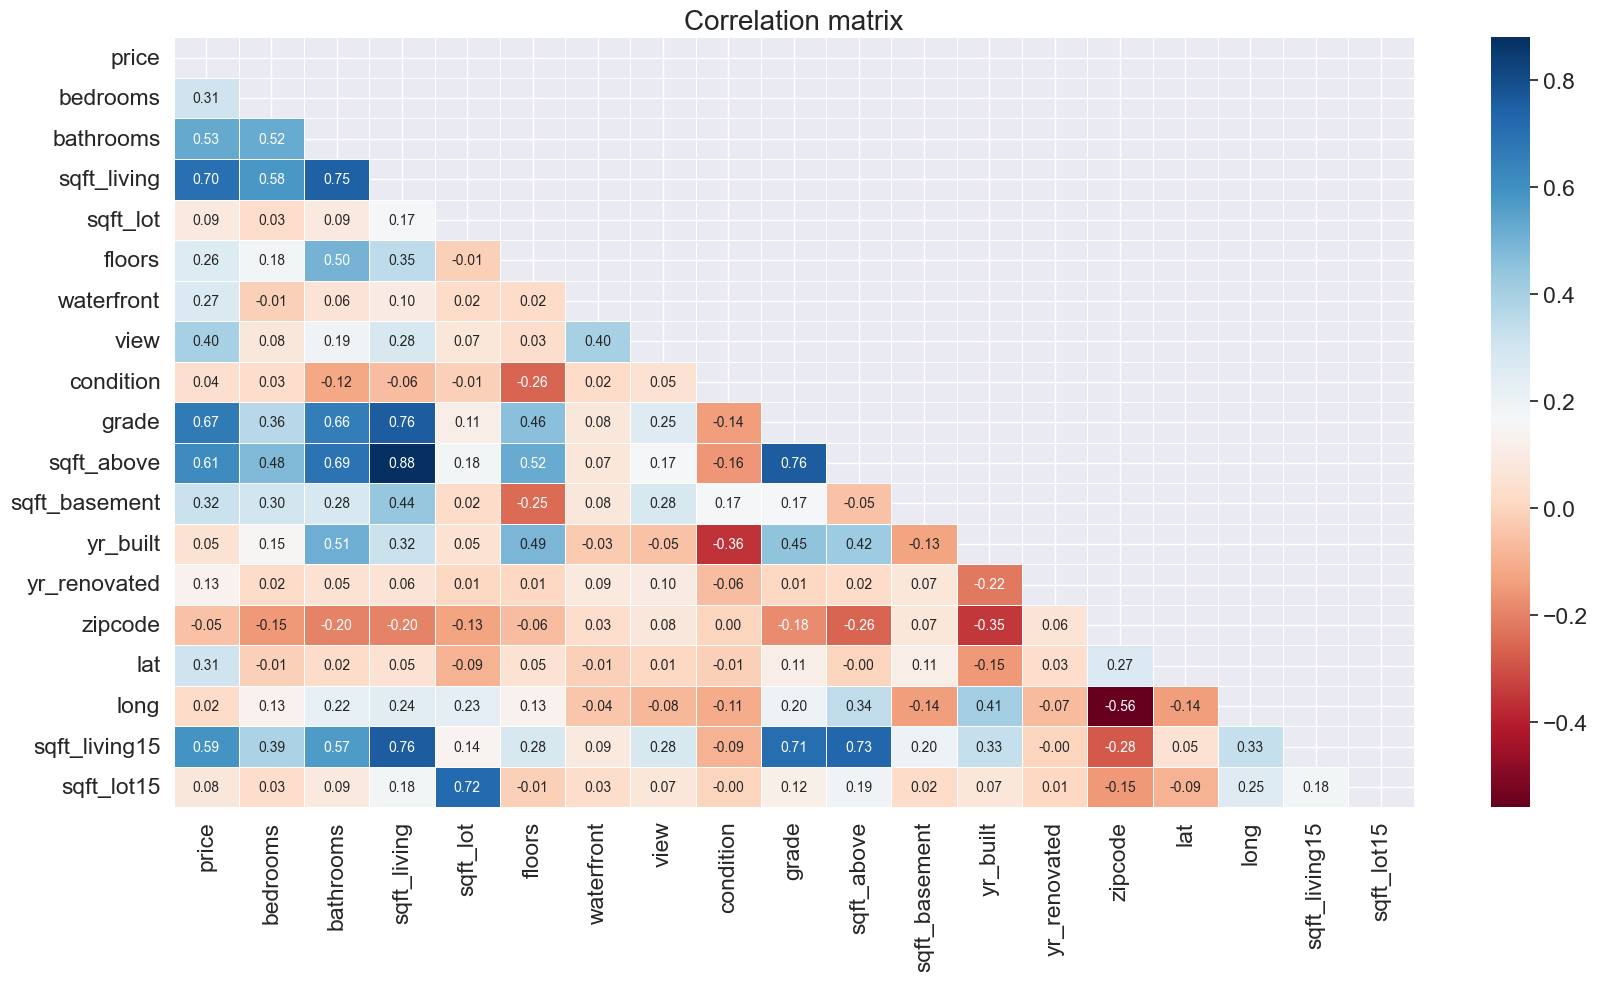

In [57]:
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1.5)

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 10}, linewidths=.5, cmap="RdBu", fmt=".2f", ax=ax)
ax.set_title("Correlation matrix", fontsize=20)
plt.show()

The above heatmap helps us better view the correlation with the target value.
It also gives us a good view of potential multicollinearity which we are going to need to deal with during the process to improve the model results.

For now I'm going to create a baseline LinearRegression model which we are going to use later on to compare the results once the less needed features are removed from the df.

In [61]:
#defining X and y

X = df.drop(columns=['id', 'date', 'price'])

y = df['price']

In [62]:
#splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [63]:
baseline_model = LinearRegression()
baseline_model

LinearRegression()

In [64]:
baseline_model.fit(X, y)
baseline_model

LinearRegression()

In [66]:
baseline_predictions = baseline_model.predict(X_test)
baseline_predictions

array([ 461823.65316824,  754768.95698617, 1245545.16559627, ...,
        376840.40130228,  819230.79093022,  579097.4203181 ],
      shape=(6484,))

In [67]:
baseline_eval = pd.DataFrame({"actual" : y_test, "pred": baseline_predictions})
baseline_eval

,actual,pred
735,365000.0,4.618237e+05
2830,865000.0,7.547690e+05
4106,1038000.0,1.245545e+06
16218,1490000.0,1.672231e+06
19964,711000.0,7.378072e+05
...,...,...
12606,412000.0,5.258836e+05
14393,760000.0,6.631789e+05
6899,410500.0,3.768404e+05
85,940000.0,8.192308e+05


In [68]:
#creating a new column to show the different between actual and predictions

baseline_eval['diff'] = abs(baseline_eval['actual'] - baseline_eval['pred'])
baseline_eval

,actual,pred,diff
735,365000.0,4.618237e+05,96823.653168
2830,865000.0,7.547690e+05,110231.043014
4106,1038000.0,1.245545e+06,207545.165596
16218,1490000.0,1.672231e+06,182231.256571
19964,711000.0,7.378072e+05,26807.180241
...,...,...,...
12606,412000.0,5.258836e+05,113883.621705
14393,760000.0,6.631789e+05,96821.089784
6899,410500.0,3.768404e+05,33659.598698
85,940000.0,8.192308e+05,120769.209070


In [72]:
#metrics of the baseline model

r2_baseline = r2_score(y_test, baseline_predictions)
RMSE_baseline = mean_squared_error(y_test, baseline_predictions)
MAE_baseline = mean_absolute_error(y_test, baseline_predictions)

#Printing the results
print("R2 = ", round(r2_baseline, 2))
print("RMSE = ", round(RMSE_baseline, 2))
print("MAE = ", round(MAE_baseline, 2))

R2 =  0.7
RMSE =  43223918065.38
MAE =  127752.47


The baseline method is giving me extreme results.
Although the R2 value shows a 70% values can be predicted by the model the RMSE and MAE are showing extreme results.

The reason for this might be that there are some extreme outliers in our df which need to be dealt with before fitting the model.

I"m now going to proceed and do the distribution observations.

In [82]:
df = df.drop(columns=['id', 'zipcode', 'waterfront', 'yr_renovated'])

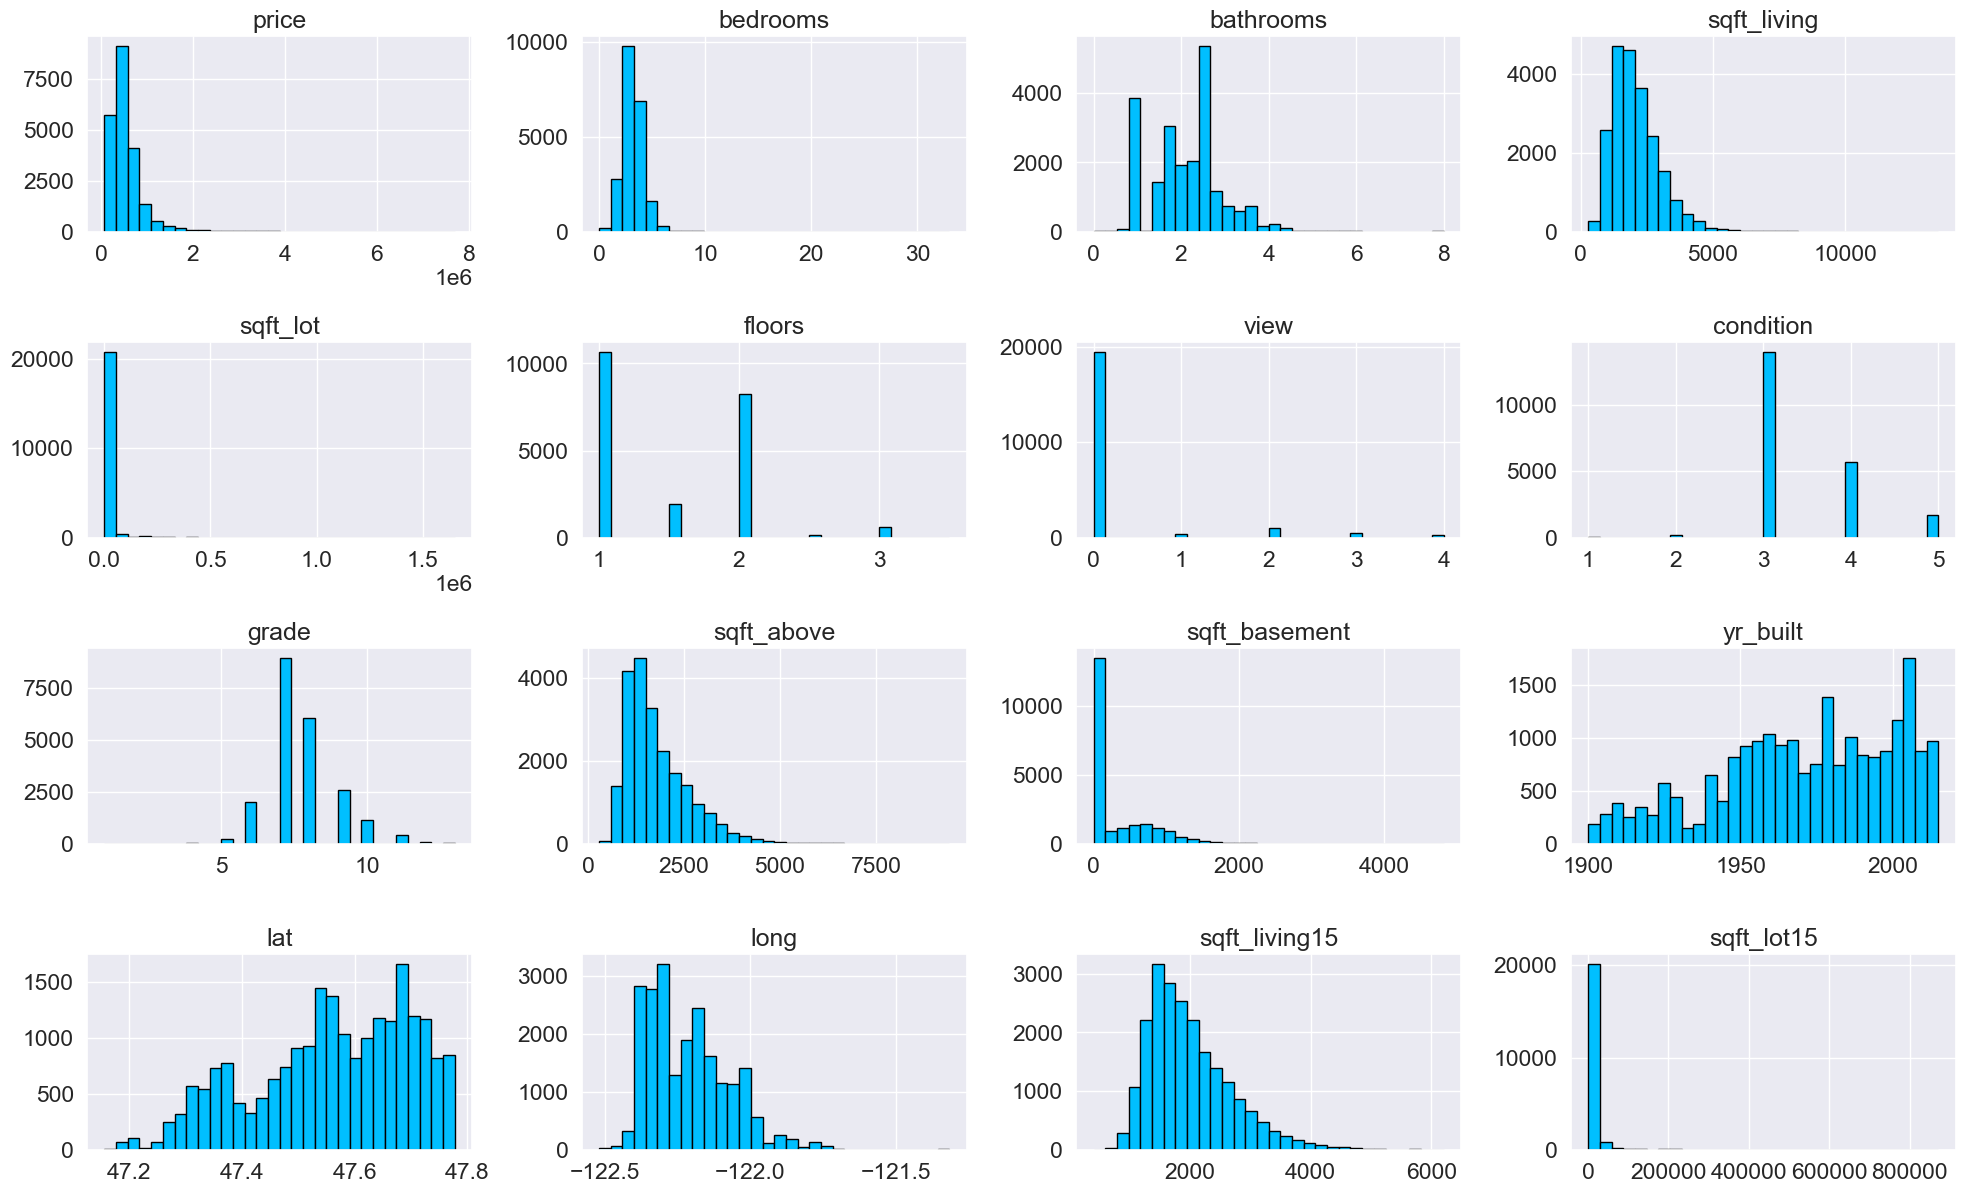

In [ ]:
color = '#00BFFF'

# grid size
nrows, ncols = 5, 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))

axes = axes.flatten()

#plotting each numerical value
for i, ax in enumerate(axes):
    if i >= len(df.columns):
        ax.set_visible(False)
        continue
    ax.hist(df.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(df.columns[i])

plt.tight_layout()
plt.show()

From the correlation matrix:

The top features impacting the value of the target are the following:

- sqft_living
- grade
- sqft_above
- sqft_living15
- bathrooms

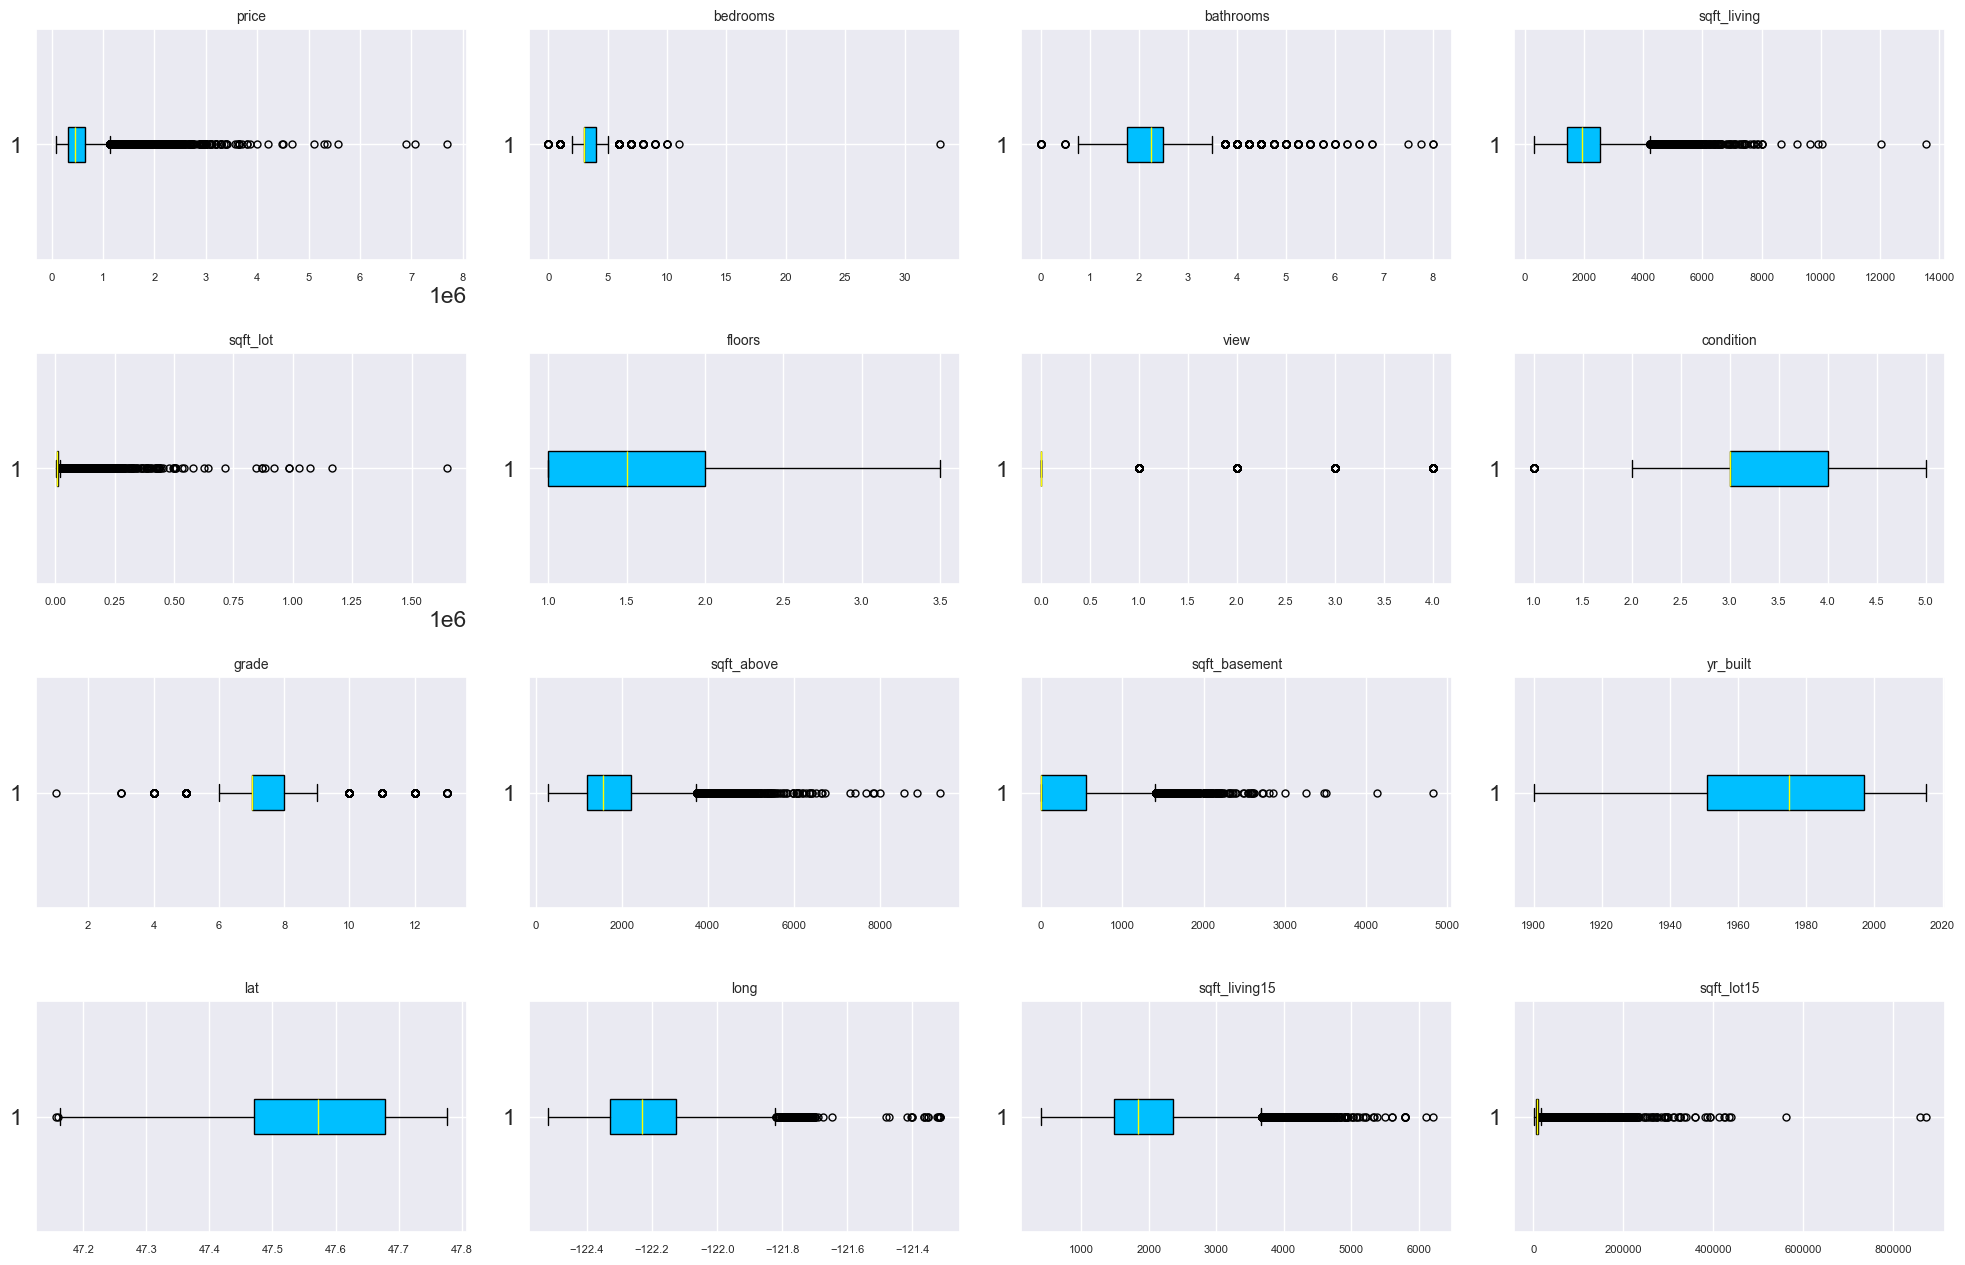

In [86]:
color = '#00BFFF'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(df.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(df.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(df.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

In [88]:
df_non_collinearity = df.copy()

df_non_collinearity = df_non_collinearity.drop(columns=['bedrooms', 'bathrooms', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15'])

df_non_collinearity

,price,sqft_living,sqft_lot,floors,view,condition,lat,long
0,221900.0,1180,5650,1.0,0,3,47.5112,-122.257
1,538000.0,2570,7242,2.0,0,3,47.7210,-122.319
2,180000.0,770,10000,1.0,0,3,47.7379,-122.233
3,604000.0,1960,5000,1.0,0,5,47.5208,-122.393
4,510000.0,1680,8080,1.0,0,3,47.6168,-122.045
...,...,...,...,...,...,...,...,...
21608,360000.0,1530,1131,3.0,0,3,47.6993,-122.346
21609,400000.0,2310,5813,2.0,0,3,47.5107,-122.362
21610,402101.0,1020,1350,2.0,0,3,47.5944,-122.299
21611,400000.0,1600,2388,2.0,0,3,47.5345,-122.069


In [121]:
model_non_collinearity = LinearRegression()

In [122]:
model_non_collinearity.fit(X_train, y_train)
model_non_collinearity

LinearRegression()

In [123]:
non_collinearity_pred = model_non_collinearity.predict(X_test)
non_collinearity_pred

array([ 458597.0676418 ,  748993.75994844, 1243303.75799066, ...,
        378358.01428268,  814280.55969628,  582157.52856987],
      shape=(6484,))

In [124]:
non_collinearity_eval = pd.DataFrame({"actual" : y_test, "pred": non_collinearity_pred})
non_collinearity_eval

,actual,pred
735,365000.0,4.585971e+05
2830,865000.0,7.489938e+05
4106,1038000.0,1.243304e+06
16218,1490000.0,1.665117e+06
19964,711000.0,7.373021e+05
...,...,...
12606,412000.0,5.226694e+05
14393,760000.0,6.565664e+05
6899,410500.0,3.783580e+05
85,940000.0,8.142806e+05


In [93]:
non_collinearity_eval['diff'] = abs(non_collinearity_eval['actual'] - non_collinearity_eval['pred'])
non_collinearity_eval

,actual,pred,diff
735,365000.0,4.618237e+05,96823.653168
2830,865000.0,7.547690e+05,110231.043014
4106,1038000.0,1.245545e+06,207545.165596
16218,1490000.0,1.672231e+06,182231.256571
19964,711000.0,7.378072e+05,26807.180241
...,...,...,...
12606,412000.0,5.258836e+05,113883.621705
14393,760000.0,6.631789e+05,96821.089784
6899,410500.0,3.768404e+05,33659.598698
85,940000.0,8.192308e+05,120769.209070


In [125]:
#metrics of the baseline model

r2_non_collinearity= r2_score(y_test, non_collinearity_pred)
RMSE_non_collinearity = mean_squared_error(y_test, non_collinearity_pred)
MAE_non_collinearity = mean_absolute_error(y_test, non_collinearity_pred)

#Printing the results
print("R2 = ", round(r2_non_collinearity, 2))
print("RMSE = ", round(RMSE_non_collinearity , 2))
print("MAE = ", round(MAE_non_collinearity, 2))

R2 =  0.7
RMSE =  43387526779.36
MAE =  127486.8


Even after removing multicollinearity the model doesn't seem to have improved.

The key to success must lie within the outliers.

As a next step I will focus on feature engineering and see how dealing with extreme values might help creating a better model.

In [141]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
    
# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
# Identify the outliers
outliers = df[(df < lower_bound) | (df > upper_bound)]

df_no_outliers = df[(df >= lower_bound) | (df <= upper_bound)]

df_no_outliers
    



,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,3,6,770,0,1933,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,3,8,1530,0,2009,47.6993,-122.346,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,3,8,2310,0,2014,47.5107,-122.362,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,0,3,7,1020,0,2009,47.5944,-122.299,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,0,3,8,1600,0,2004,47.5345,-122.069,1410,1287


In [142]:
df_no_outliers = df_no_outliers.drop(columns=['view']) 

In [143]:
df_no_outliers.sort_values(by='price', ascending= False)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
7252,7700000.0,6,8.00,12050,27600,2.5,4,13,8570,3480,1910,47.6298,-122.323,3940,8800
3914,7062500.0,5,4.50,10040,37325,2.0,3,11,7680,2360,1940,47.6500,-122.214,3930,25449
9254,6885000.0,6,7.75,9890,31374,2.0,3,13,8860,1030,2001,47.6305,-122.240,4540,42730
4411,5570000.0,5,5.75,9200,35069,2.0,3,13,6200,3000,2001,47.6289,-122.233,3560,24345
1448,5350000.0,5,5.00,8000,23985,2.0,3,12,6720,1280,2009,47.6232,-122.220,4600,21750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8274,82000.0,3,1.00,860,10426,1.0,3,6,860,0,1954,47.4987,-122.341,1140,11250
16198,81000.0,2,1.00,730,9975,1.0,1,5,730,0,1943,47.4808,-122.315,860,9000
465,80000.0,1,0.75,430,5050,1.0,2,4,430,0,1912,47.6499,-121.909,1200,7500
15293,78000.0,2,1.00,780,16344,1.0,1,5,780,0,1942,47.4739,-122.280,1700,10387


<Axes: ylabel='price'>

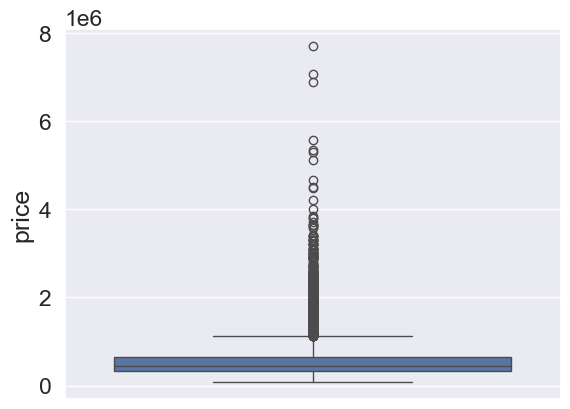

In [145]:
sns.boxplot( data= df_no_outliers['price'])

After removing outliers automatically we can still see extreme values.

I will therefore run the process once again to try and obtain an uniform distribution which will be more suitable to the regression model.

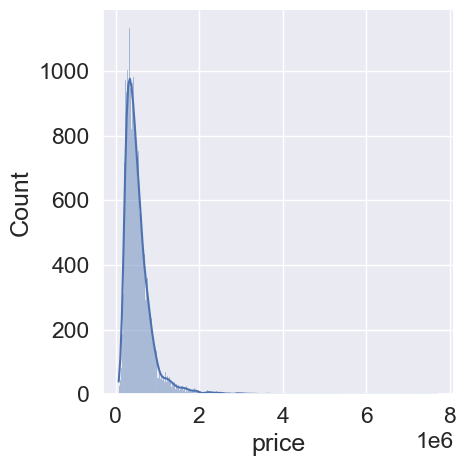

In [146]:
sns.displot( data=df_no_outliers["price"], kde=True )